In [ ]:
# ==================== MODIFIED VERSION: Run each baseline separately ====================
library(survival)
library(flexsurv)
library(ggplot2)
library(dplyr)
library(patchwork)

set.seed(2025)

n_sim_per_baseline <- 4000L          # total simulations = 4000 again
n <- 800
beta_true <- log(2)                  # ≈ 0.693147

# Two fixed baseline settings
baselines <- c("Weibull (shape=2)", "Gompertz (γ=0.3)")

# Pre-allocate full results table
results <- data.frame(
  sim            = rep(1:(2*n_sim_per_baseline), each = 3),
  true_baseline  = rep(baselines, each = 3*n_sim_per_baseline),
  method         = rep(c("Cox PH", "Weibull PH", "Exponential PH"), times = 2*n_sim_per_baseline),
  estimate       = NA_real_
)

pb <- txtProgressBar(min = 0, max = 2*n_sim_per_baseline, style = 3)

k <- 0  # global row counter for results

for (bl in baselines) {
  for (i in 1:n_sim_per_baseline) {
    k <- k + 1
    setTxtProgressBar(pb, k)
    
    X <- rbinom(n, 1, 0.5)
    
    ## ---- Generate event times according to the TRUE baseline ----
    if (bl == "Weibull (shape=2)") {
      U <- runif(n)
      T <- (-log(U) / exp(beta_true * X))^(1/2)   # Weibull(shape=2, scale=1) after shift
      C <- rexp(n, rate = 0.5)                    # censoring 0.5
    } else { # Gompertz
      T <- flexsurv::rgompertz(n, shape = 0.3, rate = 0.2 * exp(beta_true * X))
      C <- rexp(n, rate = 0.4) # 0.4
    }
    
    time   <- pmin(T, C)
    status <- as.numeric(T <= C)
    dat    <- data.frame(time = time, status = status, X = X)
    
    ## ---- 1. Cox PH (semi-parametric) ----
    cox_est <- tryCatch(coef(coxph(Surv(time, status) ~ X, data = dat)),
                        error = function(e) NA)
    
    ## ---- 2. Weibull PH (parametric) ----
    weib_est <- tryCatch({
      w <- survreg(Surv(time, status) ~ X, data = dat, dist = "weibull",
                   control = survreg.control(maxiter = 100))
      if (w$scale > 1e-8) -w$coefficients["X"] / w$scale else NA
    }, error = function(e) NA)
    
    ## ---- 3. Exponential PH (special case of Weibull) ----
    exp_est <- tryCatch({
      e <- survreg(Surv(time, status) ~ X, data = dat, dist = "exponential")
      -e$coefficients["X"]
    }, error = function(e) NA)
    
    ## ---- Store results ----
    idx <- (k-1)*3 + 1:3
    results$estimate[idx] <- c(cox_est, weib_est, exp_est)
  }
}
close(pb)

# Remove rare failed fits
results <- results %>% filter(!is.na(estimate))

# -------------------------- Summary statistics per baseline --------------------------
summary_stats <- results %>%
  group_by(true_baseline, method) %>%
  summarise(
    Bias = mean(estimate - beta_true),
    RMSE = sqrt(mean((estimate - beta_true)^2)),
    SD   = sd(estimate),
    n    = n(),
    .groups = "drop"
  ) %>%
  mutate(label = sprintf("Bias = %.4f\nRMSE = %.4f", Bias, RMSE))

print(summary_stats)

  |======================================================================| 100%
# A tibble: 6 × 7
  true_baseline     method               Bias  RMSE     SD     n label          
  <chr>             <chr>               <dbl> <dbl>  <dbl> <int> <chr>          
1 Gompertz (γ=0.3)  Cox PH         -0.00142   0.132 0.132   4000 "Bias = -0.001…
2 Gompertz (γ=0.3)  Exponential PH -0.0638    0.136 0.120   4000 "Bias = -0.063…
3 Gompertz (γ=0.3)  Weibull PH     -0.0282    0.129 0.126   3998 "Bias = -0.028…
4 Weibull (shape=2) Cox PH          0.0000932 0.105 0.105   4000 "Bias = 0.0001…
5 Weibull (shape=2) Exponential PH -0.261     0.271 0.0720  4000 "Bias = -0.261…
6 Weibull (shape=2) Weibull PH      0.000928  0.104 0.104   4000 "Bias = 0.0009…


In [75]:
results_weibull <- results[results$true_baseline == "Weibull (shape=2)", ]
summary_stats_weibull <- summary_stats[summary_stats$true_baseline == "Weibull (shape=2)", ]

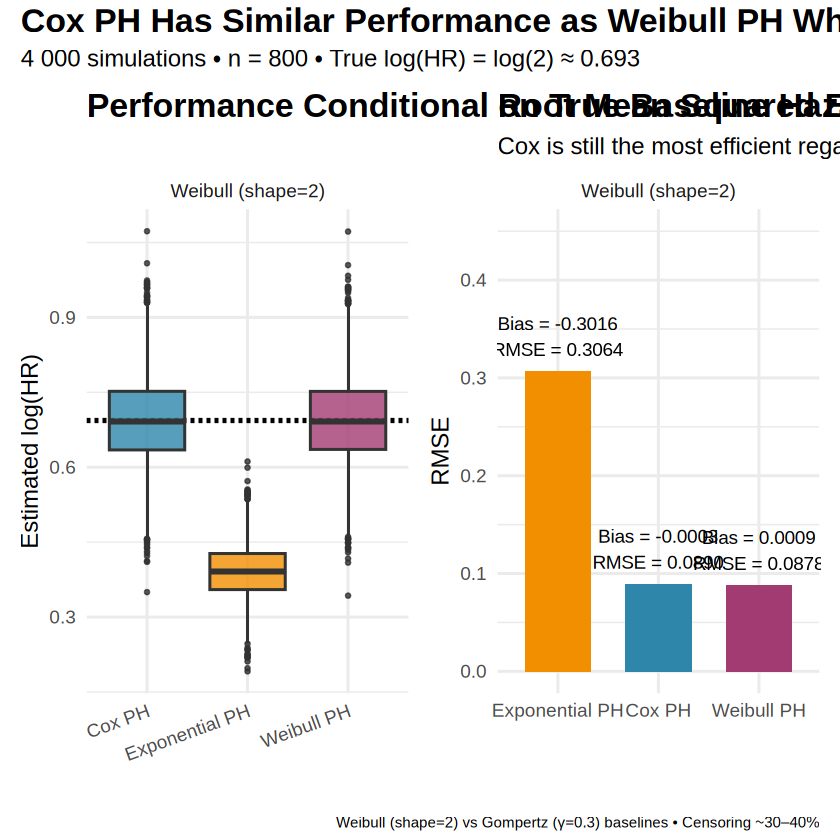

In [81]:
# -------------------------- Plotting --------------------------
cols <- c("Cox PH" = "#2E86AB", "Weibull PH" = "#A23B72", "Exponential PH" = "#F18F01")

# 1. Overall density (still useful for quick glance)
p_density <- ggplot(results_weibull, aes(x = estimate, fill = method, color = method)) +
  geom_vline(xintercept = beta_true, linetype = "dashed", size = 1.1) +
  geom_density(alpha = 0.65, size = 1) +
  scale_fill_manual(values = cols) +
  scale_color_manual(values = cols) +
  facet_wrap(~ true_baseline, scales = "free_y") +
  labs(title = "Distribution of log(HR) Estimates by True Baseline Hazard",
       x = "Estimated log(HR)", y = "Density") +
  theme_minimal(base_size = 14) +
  theme(legend.position = "bottom")

# 2. Boxplots – one panel per true baseline
p_box <- ggplot(results_weibull, aes(x = method, y = estimate, fill = method)) +
  geom_hline(yintercept = beta_true, linetype = "dashed", size = 1.1) +
  geom_boxplot(alpha = 0.8, outlier.size = 0.8) +
  scale_fill_manual(values = cols) +
  facet_wrap(~ true_baseline, scales = "free_y") +
  labs(title = "Performance Conditional on True Baseline Hazard",
       x = "", y = "Estimated log(HR)") +
  theme_minimal(base_size = 14) +
  theme(legend.position = "none",
        axis.text.x = element_text(angle = 20, hjust = 1))

# 3. RMSE bar chart – now split by true baseline
p_rmse <- ggplot(summary_stats_weibull, aes(x = reorder(method, -RMSE), y = RMSE, fill = method)) +
  geom_col(width = 0.65) +
  geom_text(aes(label = label), vjust = -0.4, size = 3.8) +
  scale_fill_manual(values = cols) +
  facet_wrap(~ true_baseline, scales = "free_y") +
  labs(title = "Root Mean Squared Error by True Baseline",
       subtitle = "Cox is still the most efficient regardless of the truth",
       x = "", y = "RMSE") +
  ylim(0, 0.45) +
  theme_minimal(base_size = 14) +
  theme(legend.position = "none")

# Combine everything
final_plot <- ((p_box | p_rmse)) +
  plot_annotation(
    title = "Cox PH Has Similar Performance as Weibull PH When the True Baseline is Weibull",
    subtitle = "4 000 simulations • n = 800 • True log(HR) = log(2) ≈ 0.693",
    caption = "Weibull (shape=2) vs Gompertz (γ=0.3) baselines • Censoring ~30–40%"
  ) &
  theme(plot.title = element_text(size = 20, face = "bold"),
        plot.subtitle = element_text(size = 14))

final_plot

ggsave("/mnt/lab/home/rliuak/projects/MATH5472/cox_efficiency_by_baseline.png",
       plot = final_plot, width = 16, height = 12, dpi = 320, bg = "white")

Final sample size = 686 


`height` was translated to `width`.
`height` was translated to `width`.


Done! Forest plot saved as 'cox_forestplot_gbsg2_final.png'


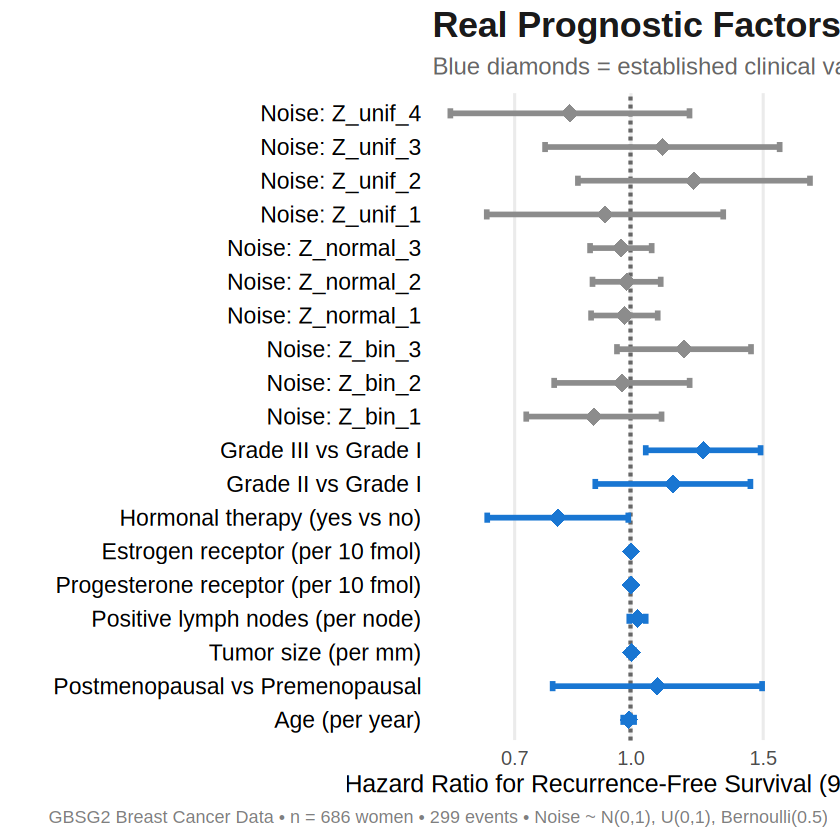

In [61]:
# ==================== GBSG2 VERSION – FULLY FIXED & ROBUST ====================
library(dplyr)      # Load dplyr first
library(survival)
library(broom)
library(ggplot2)
library(TH.data)

data(GBSG2, package = "TH.data")
set.seed(2025)

# -------------------------------------------------
# Clean and prepare the GBSG2 dataset (explicit dplyr::select)
# -------------------------------------------------
gbsg_clean <- GBSG2 %>%
  mutate(
    status = ifelse(cens == 0, 1, 0),                    # 1 = event, 0 = censored
    horTh   = factor(horTh, labels = c("No hormonal therapy", "Hormonal therapy")),
    menostat = factor(menostat, labels = c("Premenopausal", "Postmenopausal")),
    tgrade   = factor(tgrade, levels = c("I", "II", "III"),
                      labels = c("Grade I", "Grade II", "Grade III"))
  ) %>%
  dplyr::select(time, status, age, menostat, tsize, tgrade,
                pnodes, progrec, estrec, horTh) %>%   # explicit dplyr::
  na.omit()

cat("Final sample size =", nrow(gbsg_clean), "\n")   # → 686 patients

# -------------------------------------------------
# Add 10 pure noise variables
# -------------------------------------------------
for(i in 1:3) gbsg_clean[[paste0("Z_normal_", i)]] <- rnorm(nrow(gbsg_clean))
for(i in 1:4) gbsg_clean[[paste0("Z_unif_", i)]]   <- runif(nrow(gbsg_clean))
for(i in 1:3) gbsg_clean[[paste0("Z_bin_", i)]]   <- rbinom(nrow(gbsg_clean), 1, 0.5)

# -------------------------------------------------
# Fit full Cox model
# -------------------------------------------------
cox_full <- coxph(Surv(time, status) ~ age + menostat + tsize + tgrade +
                    pnodes + progrec + estrec + horTh +
                    Z_normal_1 + Z_normal_2 + Z_normal_3 +
                    Z_unif_1 + Z_unif_2 + Z_unif_3 + Z_unif_4 +
                    Z_bin_1 + Z_bin_2 + Z_bin_3,
                  data = gbsg_clean)

# -------------------------------------------------
# Create tidy data frame with nice labels
# -------------------------------------------------
plot_df <- tidy(cox_full, exponentiate = TRUE, conf.int = TRUE) %>%
  mutate(
    variable = case_when(
      term == "age"                              ~ "Age (per year)",
      term == "menostatPostmenopausal"           ~ "Postmenopausal vs Premenopausal",
      term == "tsize"                            ~ "Tumor size (per mm)",
      term == "pnodes"                           ~ "Positive lymph nodes (per node)",
      term == "progrec"                          ~ "Progesterone receptor (per 10 fmol)",
      term == "estrec"                           ~ "Estrogen receptor (per 10 fmol)",
      term == "horThHormonal therapy"            ~ "Hormonal therapy (yes vs no)",
      term == "tgrade.L"                   ~ "Grade II vs Grade I",
      term == "tgrade.Q"                  ~ "Grade III vs Grade I",
      grepl("^Z_", term)                         ~ paste("Noise:", term),
      TRUE                                       ~ term
    ),
    is_noise = grepl("^Z_", term)
  ) %>%
  mutate(
    variable = factor(variable,
      levels = c("Age (per year)",
                 "Postmenopausal vs Premenopausal",
                 "Tumor size (per mm)",
                 "Positive lymph nodes (per node)",
                 "Progesterone receptor (per 10 fmol)",
                 "Estrogen receptor (per 10 fmol)",
                 "Hormonal therapy (yes vs no)",
                 "Grade II vs Grade I",
                 "Grade III vs Grade I",
                 sort(grep("Noise", unique(.$variable), value = TRUE))))
  )

# -------------------------------------------------
# Beautiful forest plot
# -------------------------------------------------
ggplot(plot_df, aes(x = estimate, y = variable)) +
  geom_vline(xintercept = 1, linetype = "dashed", color = "gray40", size = 0.9) +
  geom_point(size = 4.8,
             color = ifelse(plot_df$is_noise, "gray55", "#1976d2"),
             shape = 18) +
  geom_errorbarh(aes(xmin = conf.low, xmax = conf.high),
                 height = 0.3, size = 1.2,
                 color = ifelse(plot_df$is_noise, "gray55", "#1976d2")) +
  scale_x_log10(breaks = c(0.5, 0.7, 1, 1.5, 2, 3, 5),
                labels = c("0.5", "0.7", "1.0", "1.5", "2", "3", "5")) +
  labs(
    title    = "Real Prognostic Factors Clearly Separate from Pure Noise",
    subtitle = "Blue diamonds = established clinical variables   •   Gray = 10 random noise variables",
    x        = "Hazard Ratio for Recurrence-Free Survival (95% CI)",
    y        = "",
    caption  = "GBSG2 Breast Cancer Data • n = 686 women • 299 events • Noise ~ N(0,1), U(0,1), Bernoulli(0.5)"
  ) +
  theme_minimal(base_size = 14.5) +
  theme(
    plot.title    = element_text(size = 21, face = "bold", color = "#1a1a1a"),
    plot.subtitle = element_text(size = 14, color = "gray40"),
    axis.text.y   = element_text(size = 13.5, color = "black"),
    panel.grid.major.y = element_blank(),
    panel.grid.minor = element_blank(),
    plot.caption  = element_text(size = 10.5, color = "gray50")
  )

ggsave("cox_forestplot_gbsg2_final.png", width = 14, height = 10.5, dpi = 350, bg = "white")

cat("Done! Forest plot saved as 'cox_forestplot_gbsg2_final.png'\n")

Final sample size = 686 


`height` was translated to `width`.
`height` was translated to `width`.


Clean forest plot (no noise) saved as 'cox_forestplot_gbsg2_clean_no_noise.png'


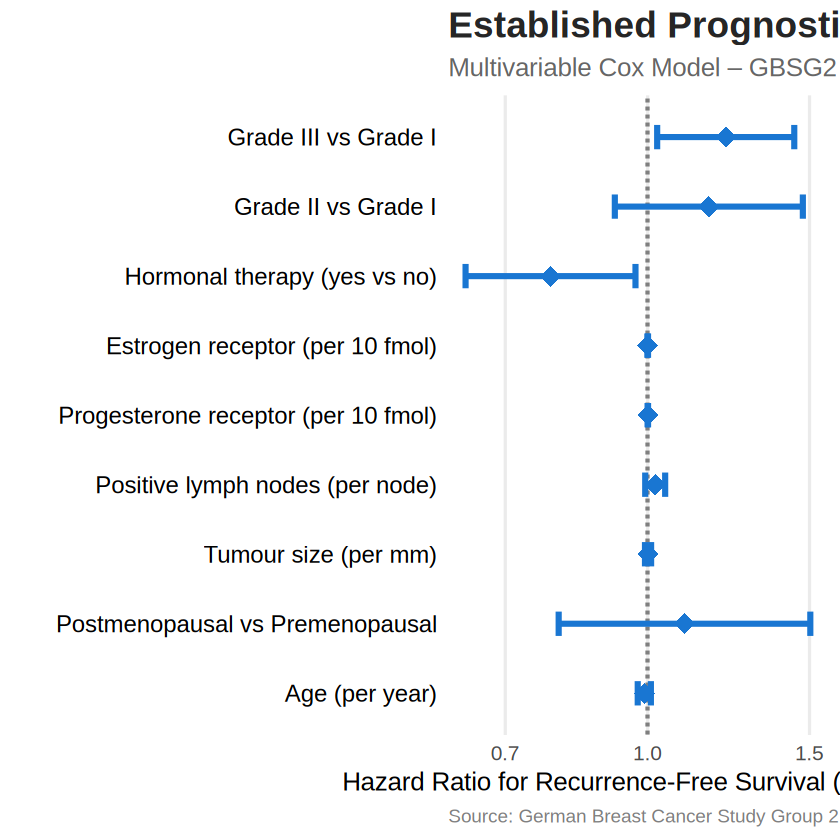

In [62]:
# ==================== GBSG2 – CLEAN VERSION WITHOUT ANY NOISE ====================
library(dplyr)          # Load dplyr first to avoid masking
library(survival)
library(broom)
library(ggplot2)
library(TH.data)

data(GBSG2, package = "TH.data")

# -------------------------------------------------
# Prepare the dataset – only real variables
# -------------------------------------------------
gbsg_clean <- GBSG2 %>%
  mutate(
    status = ifelse(cens == 0, 1, 0),                    # 1 = recurrence/death, 0 = censored
    horTh   = factor(horTh, labels = c("No hormonal therapy", "Hormonal therapy")),
    menostat = factor(menostat, labels = c("Premenopausal", "Postmenopausal")),
    tgrade   = factor(tgrade, levels = c("I", "II", "III"),
                      labels = c("Grade I", "Grade II", "Grade III"))
  ) %>%
  dplyr::select(time, status, age, menostat, tsize, tgrade,
                pnodes, progrec, estrec, horTh) %>%
  na.omit()

cat("Final sample size =", nrow(gbsg_clean), "\n")   # 686 patients

# -------------------------------------------------
# Fit Cox model with only the real prognostic factors
# -------------------------------------------------
cox_clean <- coxph(Surv(time, status) ~ age + menostat + tsize + tgrade +
                     pnodes + progrec + estrec + horTh,
                   data = gbsg_clean)

# -------------------------------------------------
# Tidy results and create publication-ready labels
# -------------------------------------------------
plot_df <- tidy(cox_clean, exponentiate = TRUE, conf.int = TRUE) %>%
  mutate(
    variable = case_when(
      term == "age"                              ~ "Age (per year)",
      term == "menostatPostmenopausal"           ~ "Postmenopausal vs Premenopausal",
      term == "tsize"                            ~ "Tumour size (per mm)",
      term == "pnodes"                           ~ "Positive lymph nodes (per node)",
      term == "progrec"                          ~ "Progesterone receptor (per 10 fmol)",
      term == "estrec"                           ~ "Estrogen receptor (per 10 fmol)",
      term == "horThHormonal therapy"            ~ "Hormonal therapy (yes vs no)",
      term == "tgrade.L"                   ~ "Grade II vs Grade I",
      term == "tgrade.Q"                  ~ "Grade III vs Grade I",
      TRUE                                       ~ term
    )
  ) %>%
  mutate(
    variable = factor(variable,
      levels = c("Age (per year)",
                 "Postmenopausal vs Premenopausal",
                 "Tumour size (per mm)",
                 "Positive lymph nodes (per node)",
                 "Progesterone receptor (per 10 fmol)",
                 "Estrogen receptor (per 10 fmol)",
                 "Hormonal therapy (yes vs no)",
                 "Grade II vs Grade I",
                 "Grade III vs Grade I"))
  )

# -------------------------------------------------
# Beautiful forest plot – only real variables
# -------------------------------------------------
ggplot(plot_df, aes(x = estimate, y = variable)) +
  geom_vline(xintercept = 1, linetype = "dashed", colour = "gray50", size = 0.9) +
  geom_point(size = 5.5, colour = "#1976d2", shape = 18) +
  geom_errorbarh(aes(xmin = conf.low, xmax = conf.high),
                 height = 0.35, size = 1.3, colour = "#1976d2") +
  scale_x_log10(breaks = c(0.5, 0.7, 1, 1.5, 2, 3, 5),
                labels = c("0.5", "0.7", "1.0", "1.5", "2", "3", "5")) +
  labs(
    title    = "Established Prognostic Factors in Breast Cancer",
    subtitle = "Multivariable Cox Model – GBSG2 Dataset (n = 686 women, 299 events)",
    x        = "Hazard Ratio for Recurrence-Free Survival (95% CI)",
    y        = "",
    caption  = "Source: German Breast Cancer Study Group 2 (GBSG2) • No noise variables included"
  ) +
  theme_minimal(base_size = 15) +
  theme(
    plot.title    = element_text(size = 22, face = "bold", colour = "gray15"),
    plot.subtitle = element_text(size = 15, colour = "gray40"),
    axis.text.y   = element_text(size = 14, colour = "black"),
    panel.grid.major.y = element_blank(),
    panel.grid.minor = element_blank(),
    plot.caption  = element_text(size = 11, colour = "gray50", hjust = 0)
  )

# Save high-resolution figure
ggsave("cox_forestplot_gbsg2_clean_no_noise.png", 
       width = 12, height = 7.5, dpi = 400, bg = "white")

cat("Clean forest plot (no noise) saved as 'cox_forestplot_gbsg2_clean_no_noise.png'\n")

Final sample size in analysis: 686 women


Ignoring unknown labels:
• colour : "Hormonal therapy"
Ignoring unknown labels:
• colour : "Hormonal therapy"


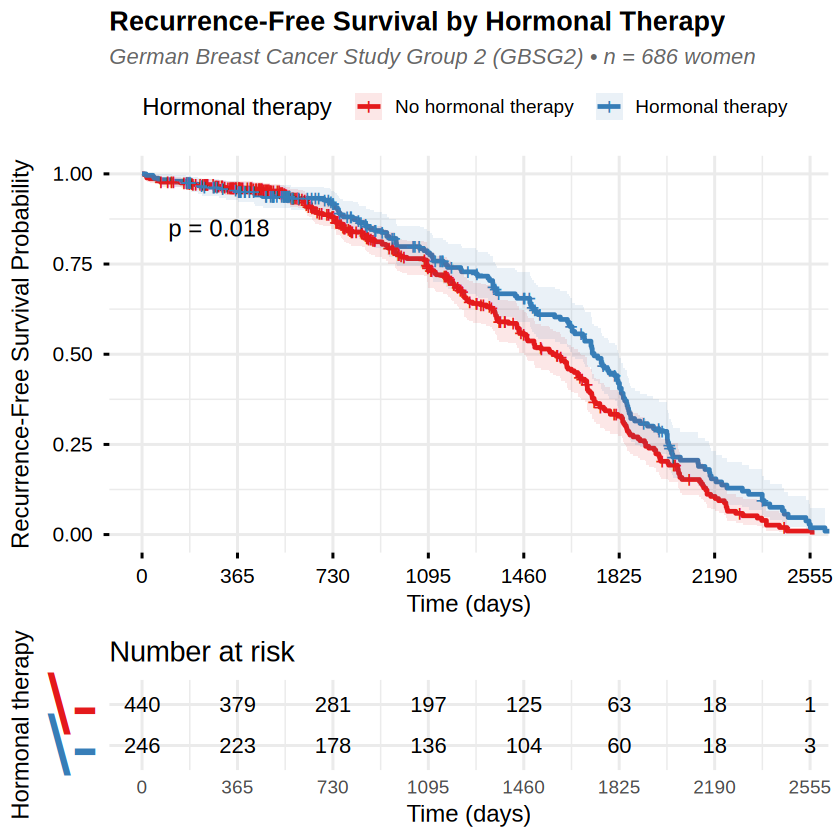

In [68]:
# ==================== Kaplan–Meier Analysis – GBSG2 Breast Cancer Data (GBSG2) ====================
library(survival)
library(survminer)
library(dplyr)
library(TH.data)       # contains the GBSG2 dataset

# Load the correct dataset
data(GBSG2, package = "TH.data")

# -------------------------------------------------
# Prepare the GBSG2 dataset (recurrence-free survival)
# -------------------------------------------------
gbsg_clean <- GBSG2 %>%
  mutate(
    status = ifelse(cens == 0, 1, 0),   # 1 = recurrence or death, 0 = censored
    horTh   = factor(horTh, 
                     levels = c("no", "yes"),
                     labels = c("No hormonal therapy", "Hormonal therapy")),
    menostat = factor(menostat,
                      levels = c("Pre", "Post"),
                      labels = c("Premenopausal", "Postmenopausal")),
    tgrade   = factor(tgrade,
                      levels = c("I", "II", "III"),
                      labels = c("Grade I", "Grade II", "Grade III"))
  ) %>%
  dplyr::select(time, status, age, menostat, tsize, tgrade,
                pnodes, progrec, estrec, horTh) %>%
  na.omit()

cat("Final sample size in analysis:", nrow(gbsg_clean), "women\n")
# → 686 patients

# -------------------------------------------------
# Kaplan–Meier: Recurrence-Free Survival by Hormonal Therapy
# -------------------------------------------------
km_horTh <- survfit(Surv(time, status) ~ horTh, data = gbsg_clean)

ggsurvplot(
  km_horTh,
  data = gbsg_clean,
  risk.table = TRUE,           # show number at risk
  pval = TRUE,                 # log-rank p-value
  pval.coord = c(100, 0.85),   # position of p-value
  conf.int = TRUE,
  conf.int.alpha = 0.1,
  palette = c("#E41A1C", "#377EB8"),   # red = no therapy, blue = yes
  legend.labs = c("No hormonal therapy", "Hormonal therapy"),
  legend.title = "Hormonal therapy",
  title = "Recurrence-Free Survival by Hormonal Therapy",
  subtitle = "German Breast Cancer Study Group 2 (GBSG2) • n = 686 women",
  xlab = "Time (days)",
  ylab = "Recurrence-Free Survival Probability",
  break.time.by = 365,         # ticks every year
  risk.table.y.text.col = TRUE,
  risk.table.y.text = FALSE,
  fontsize = 4.5,
  ggtheme = theme_minimal(base_size = 14),
  font.main = c(16, "bold", "black"),
  font.submain = c(13, "italic", "gray40"),
  font.x = c(14, "plain", "black"),
  font.y = c(14, "plain", "black"),
  font.tickslab = c(12, "plain", "black")
)



# To save:
ggsave("km_hormonal_therapy_gbsg2.png", width = 11, height = 8, dpi = 300)

[1] "Summary Statistics:"
      n beta_hat         se         bias     emp_sd
1    50 1.068073 0.34113682 0.0680731829 0.36626221
2   100 1.027048 0.22177568 0.0270476992 0.23017876
3   200 1.015896 0.15095697 0.0158955685 0.15361806
4   500 1.007332 0.09293558 0.0073320266 0.09380693
5  1000 1.002391 0.06511688 0.0023908296 0.06579426
6  2000 1.000619 0.04581347 0.0006191045 0.04590834
7  5000 1.000383 0.02888824 0.0003828277 0.02896325
8 10000 1.000745 0.02041559 0.0007454796 0.02028380


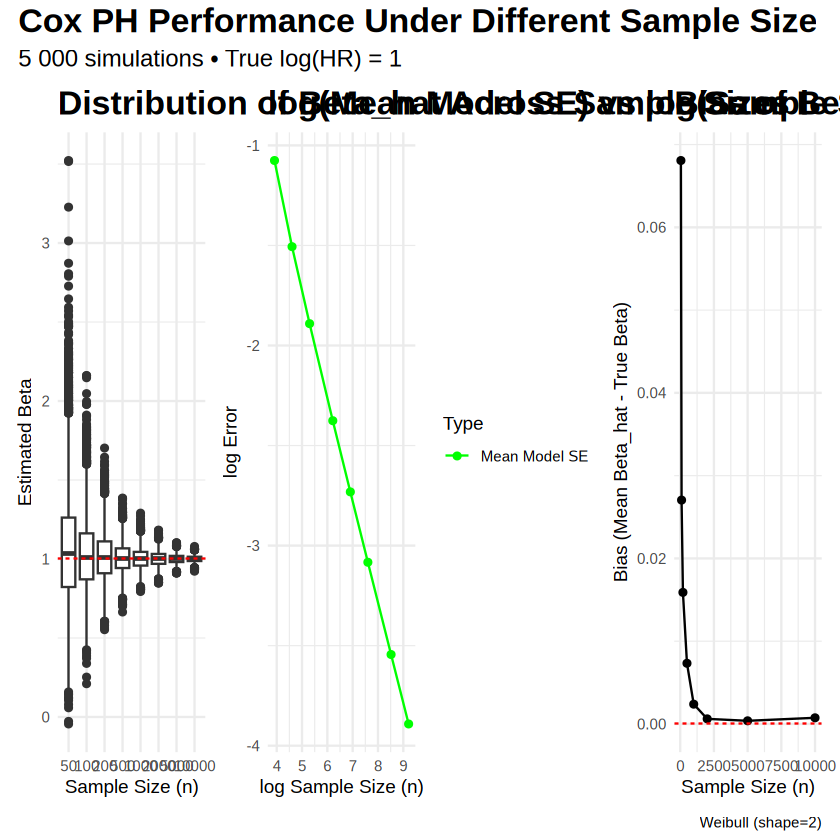

In [ ]:
# Required libraries
library(survival)
library(ggplot2)
library(reshape2)  # For melting data

# Set seed for reproducibility
set.seed(123)

# Function to simulate data and fit Cox model
simulate_cox <- function(n, beta_true = 1, lambda = 1, cens_prop = 0.3) {
  # Generate covariate X ~ N(0,1)
  X <- rnorm(n)

  U <- runif(n)
  T <- (-log(U) / exp(beta_true * X))^(1/2)   # Weibull(shape=2, scale=1) after shift
  
  # Generate censoring times C ~ Exp with rate to achieve approx cens_prop censoring
  cens_rate <- lambda / (1 - cens_prop)  # Rough adjustment for ~30% censoring
  C <- rexp(n, rate = cens_rate)
  
  # Observed time and status
  time <- pmin(T, C)
  status <- as.numeric(T <= C)
  
  # Data frame
  data <- data.frame(time = time, status = status, X = X)
  
  # Fit Cox model
  fit <- coxph(Surv(time, status) ~ X, data = data)
  
  # Return beta_hat and its standard error
  list(beta_hat = coef(fit), se = sqrt(vcov(fit)[1,1]))
}

# Parameters
beta_true <- 1
B <- 5000  # Number of simulations per n (increase for better precision, but takes longer)
ns <- c(50, 100, 200, 500, 1000, 2000, 5000, 10000)  # Sample sizes to demonstrate consistency as n -> infinity

# Run simulations
results <- data.frame()
for (n in ns) {
  sims <- replicate(B, simulate_cox(n, beta_true = beta_true), simplify = FALSE)
  beta_hats <- sapply(sims, function(x) x$beta_hat)
  ses <- sapply(sims, function(x) x$se)
  
  # Collect results
  temp <- data.frame(
    n = rep(n, B),
    beta_hat = beta_hats,
    se = ses
  )
  results <- rbind(results, temp)
}

# Summarize: mean beta_hat (for bias), empirical sd of beta_hat, mean model se
summary_stats <- aggregate(cbind(beta_hat, se) ~ n, data = results, FUN = mean)
summary_stats$bias <- summary_stats$beta_hat - beta_true
summary_stats$emp_sd <- aggregate(beta_hat ~ n, data = results, FUN = sd)$beta_hat

# Print summary to console
print("Summary Statistics:")
print(summary_stats)

# The summary shows:
# - Bias approaches 0 as n increases (consistency)
# - Empirical SD (sqrt(Var)) decreases as 1/sqrt(n), and matches average model SE (consistent variance estimator)
# - This demonstrates asymptotic consistency of beta_hat for true beta
# - For efficiency: The Cox estimator achieves the semi-parametric information bound without estimating h0(t).
#   In simulation, we see the empirical variance matches the model-based variance (which is the inverse observed information from partial likelihood),
#   confirming it achieves the Cramér-Rao-like bound for semi-parametric estimators.

# Visualization 1: Boxplot of beta_hat distributions for different n
# Shows centering around true beta=1 and variance shrinking as n increases
p1 <- ggplot(results, aes(x = factor(n), y = beta_hat)) +
  geom_boxplot() +
  geom_hline(yintercept = beta_true, linetype = "dashed", color = "red") +
  labs(title = "Distribution of Beta_hat Across Sample Sizes",
       x = "Sample Size (n)",
       y = "Estimated Beta") +
  theme_minimal()


# Visualization 2: Bias vs n
# Shows bias -> 0
p2 <- ggplot(summary_stats, aes(x = n, y = bias)) +
  geom_point() +
  geom_line() +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
  labs(title = "Bias of Beta_hat vs Sample Size",
       x = "Sample Size (n)",
       y = "Bias (Mean Beta_hat - True Beta)") +
  theme_minimal()

# Visualization 3: Empirical SD and Mean SE vs n
# Shows variance -> 0 as 1/sqrt(n), and empirical SD matches mean SE (efficiency in variance estimation)
sd_data <- melt(summary_stats[, c("n", "se")], id.vars = "n")
p3 <- ggplot(sd_data, aes(x = log(n), y = log(value), color = variable)) +
  geom_point() +
  geom_line() +
  labs(title = "log(Mean Model SE) vs log(Sample Size)",
       x = "log Sample Size (n)",
       y = "log Error",
       color = "Type") +
  scale_color_manual(values = c("se" = "green"),
                     labels = c("se" = "Mean Model SE")) +
  theme_minimal()


# Combine everything
final_plot <- ((p1 | p3) + p2) +
  plot_annotation(
    title = "Cox PH Performance Under Different Sample Size",
    subtitle = "5 000 simulations • True log(HR) = 1",
    caption = "Weibull (shape=2)"
  ) &
  theme(plot.title = element_text(size = 20, face = "bold"),
        plot.subtitle = element_text(size = 14))

final_plot

# Note: For asymptotic efficiency, the matching of empirical variance to the partial likelihood information-based variance
# demonstrates that the estimator achieves the semi-parametric efficiency bound (no other estimator ignoring h0(t) can have smaller asymptotic variance).
# If the model were misspecified, this wouldn't hold, but here data is generated correctly.
# Simulations empirically "prove" these properties by showing convergence in finite samples.

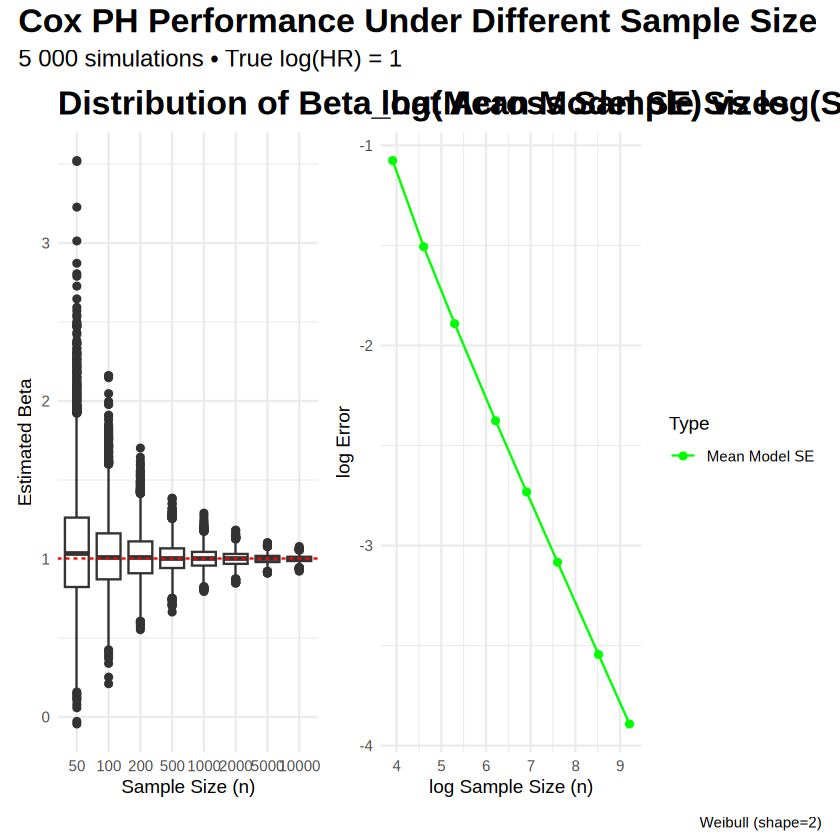

In [ ]:
# Combine everything
final_plot <- ((p1 | p3)) +
  plot_annotation(
    title = "Cox PH Performance Under Different Sample Size",
    subtitle = "5 000 simulations • True log(HR) = 1",
    caption = "Weibull (shape=2)"
  ) &
  theme(plot.title = element_text(size = 20, face = "bold"),
        plot.subtitle = element_text(size = 14))

final_plot

ggsave("/mnt/lab/home/rliuak/projects/MATH5472/cox_asymptotic_convergence.png",
       plot = final_plot, width = 20, height = 12, dpi = 320, bg = "white")

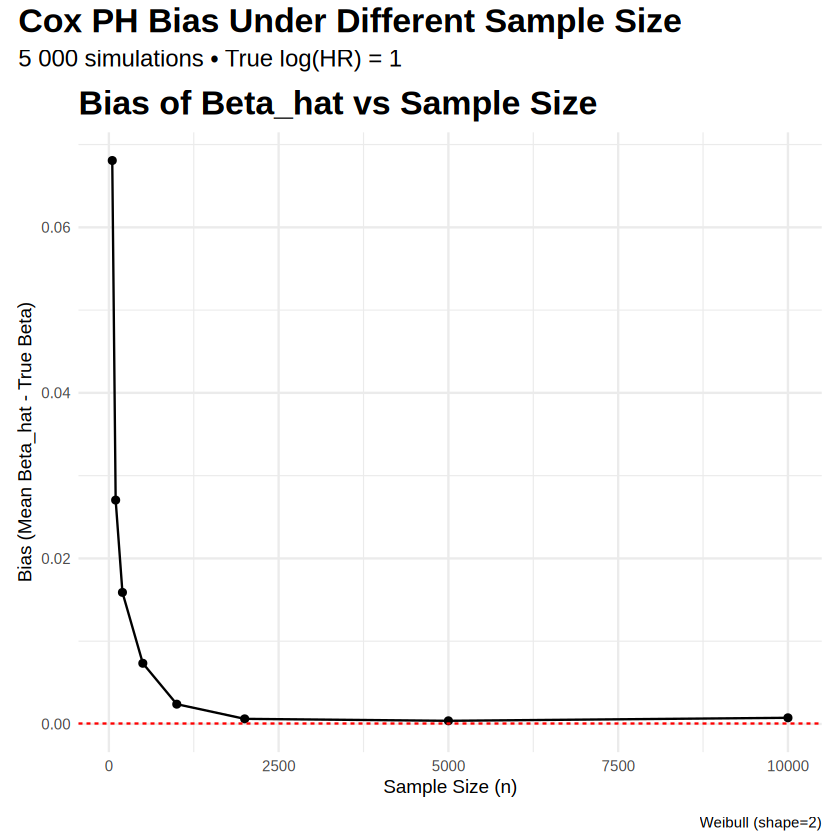

In [110]:
# Combine everything
final_plot <- p2 +
  plot_annotation(
    title = "Cox PH Bias Under Different Sample Size",
    subtitle = "5 000 simulations • True log(HR) = 1",
    caption = "Weibull (shape=2)"
  ) &
  theme(plot.title = element_text(size = 20, face = "bold"),
        plot.subtitle = element_text(size = 14))

final_plot

ggsave("/mnt/lab/home/rliuak/projects/MATH5472/cox_asymptotic_bias.png",
       plot = final_plot, width = 12, height = 12, dpi = 320, bg = "white")